In [4]:
!pip install tensorflow_datasets

     |████████████████████████████████| 3.7 MB 11 kB/s  eta 0:00:01
     |████████████████████████████████| 81 kB 209 kB/s eta 0:00:01
     |████████████████████████████████| 47 kB 240 kB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=d204994ec5efc715ad885d8717a4625d2f0fff213e52844c02fe8b8a080157b6
  Stored in directory: /home/hj20/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built promise


In [9]:
!pip install pytest-astropy

In [5]:
#설정
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
print(tf.__version__)#tensorflow 버전 확인

2.4.1


In [7]:
#꽃 데이터세트 다운로드하기 
import pathlib
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

/home/hj20/.keras/datasets/flower_photos


```  tf.keras.utils.get_file() 인터넷 상의 파일을 다운받는 함수
```


In [11]:
#다운로드한 후 꽃 사진의 사본을 사용 총 3670 개의 이미지
image_count = len(list(data_dir.glob('*/*.jpg')))#data_dir에서 jpg 파일 리스트 출력 
print(image_count)

3670


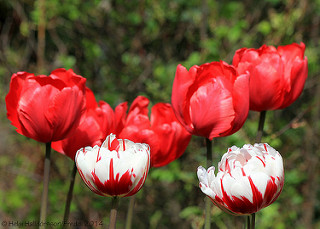

In [12]:
#각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있다. 다음은 장미
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### keras.preprocessing 을 사용하여 로드하기

In [13]:
#데이터 세트 만들기 
batch_size = 32
img_height = 180
img_width = 180

In [16]:
#모델을 개발할 때 검증 분할을 사용하는 것이 좋다 훈련에 이미지의 80을 사용하고 검증에 20을 사용
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
3670*0.8

2936.0

In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
3670*0.2

734.0

In [20]:
#5개 종류의 꽃
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


- 데이터 시각화 하기  
훈련 데이터세트의 처음 9개 이미지는 다음과 같다

In [21]:
train_ds.take(1) #180*180*3 형상의 (마지막 차원은 색상 채널 RGB를 나타냄)

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

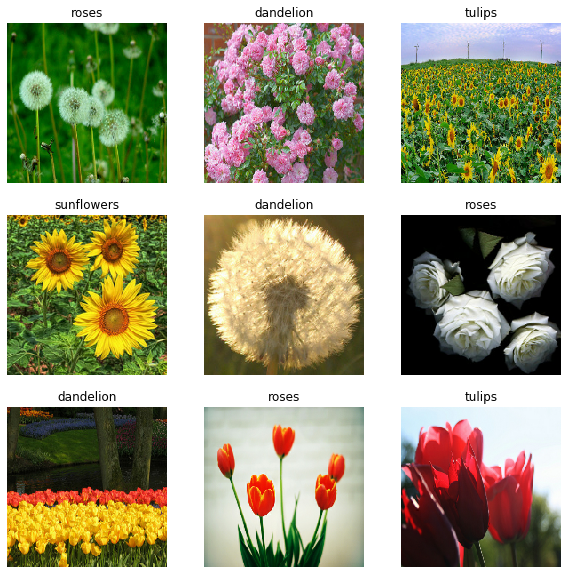

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labes in train_ds.take(1):#튜플(데이터,라벨)을 반환
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

이러한 데이터세트를 사용하는 모델을 ```model.fit```에 전달하여 모델을 훈련, 원하는 경우 데이터세트를 수동으로 반복하고 이미지 배치를 검색

In [26]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


```image_batch``` 는 형상 (32,180,180,3)의 텐서이다. 이것은 형상```180x180x3``` 의32개 이미지 배치(마지막 치수는 채널 RGB를 나타냄)
```label_batch```는 형상 ```(32,)``` 의 텐서이며 32개 이미지에 해당하는 레이블이다

참고: 이들 텐서 중 하나에서 ```.numpy()```를 호출하여 ```numpy.ndarray``` 로 변환 가능

- 데이터 표준화 하기  
RGB 채널 값은 `[0,255]` 범위에 있다. 신경망에는 이상적이지 않다. 일반적으로 입력 값을 작게 만들어야 한다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0,1]` 에 있도록 표준화

In [27]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [29]:
#위 레이어를 사용하는 방법에는 두 가지가 있다. map을 호출하여 데이터세트에 레이어를 적용

normalized_ds = train_ds.map(lambda x, y:(normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

#Notice the pixels values are now in '[0,1]'.

print(np.min(first_image),np.max(first_image))

0.0 1.0


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있다. 여기서는 두번째 접근 방식을 사용할 것이다.  

참고: 픽셀 값을 `[-1,1]` 으로 조정하려면 대신 `Rescaling(1./127.5,offset=-1)`를 작성할 수 있다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.

- 성능을 위한 데이터세트 구성하기  

버퍼링된 프리페치를 사용하여 i/o 가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 한다. 데이터를 로드할때 사용해야하는 두 가지 중요한 메서드이다.  

    - `cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지한다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않는다. 데이터 세트가 너무 커서 메모리에 맞지 않는 경우 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있다.
    - `.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹침
   

In [31]:
#파이프라이닝
#데이터가 소비되는 시간과 데이터가 생성되는 시간 간의 의존성을 줄임
#tf.data 런타임이 실행시에 동적으로 값을 조정하도록 만든다
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

- 모델 훈련하기  
    완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줌
    

In [32]:
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [34]:
model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 31s 329ms/step - loss: 1.4836 - accuracy: 0.3282 - val_loss: 1.0832 - val_accuracy: 0.5504
Epoch 2/3
92/92 [==============================] - 29s 317ms/step - loss: 1.0232 - accuracy: 0.5830 - val_loss: 0.9778 - val_accuracy: 0.6049
Epoch 3/3
92/92 [==============================] - 29s 317ms/step - loss: 0.8682 - accuracy: 0.6646 - val_loss: 0.9883 - val_accuracy: 0.5858


검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있다. 

### 미세 제어를 위해 tf.data 사용하기
위의 keras.preprocessing 유틸리티는 이미지의 디렉토리에서 `tf.data.Dataset`을 작성하는 편리한 방법이다. 보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성할 수 있다. 이 섹션에서는 이전에 다운로드한 zip파일 경로부터 시작하여 이를 수행하는 방법을 보여줌

In [35]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'),shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [36]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/hj20/.keras/datasets/flower_photos/roses/14414117598_cf70df30de.jpg'
b'/home/hj20/.keras/datasets/flower_photos/roses/18741313803_1bbf842fc6_n.jpg'
b'/home/hj20/.keras/datasets/flower_photos/sunflowers/3681233294_4f06cd8903.jpg'
b'/home/hj20/.keras/datasets/flower_photos/dandelion/7040710179_7f86a17a3c_n.jpg'
b'/home/hj20/.keras/datasets/flower_photos/dandelion/4858372040_52216eb0bd.jpg'


In [40]:
#파일의 트리 구조를 사용하여 class_names목록 컴파일 sorted 정렬
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
#name -> data_dir 파일 명 

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 훈련 및 검증으로 분할

In [59]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 볼 수 있다.

In [60]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img,label)` 쌍으로 변환하는 간단한 함수를 작성

In [61]:
def get_label(file_path):
    #convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    #the second to last is the class-directory
    one_hot = parts[-2] == class_names
    #Integer encode the label
    return tf.argmax(one_hot)

In [62]:
def decode_img(img):
    #conver the compressed string to a 3D unit8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    #resize the image to the desired size
    return tf.image.resize(img,[img_height,img_width])


In [63]:
def process_path(file_path):
    label = get_label(file_path)
    #load the raw data from the file as a string
    
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

`Dataset.map`을 사용하여 `image,label` 쌍의 데이터세트를 작성

In [64]:
#set 'num_parallel_calls' sp multiple images are loaded/processed in parallel
train_ds = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [70]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### 성능을 위한 데이터세트 구성하기  
이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요
- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.


In [71]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
    

### 데이터 시각화하기
이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화할 수 있습니다.


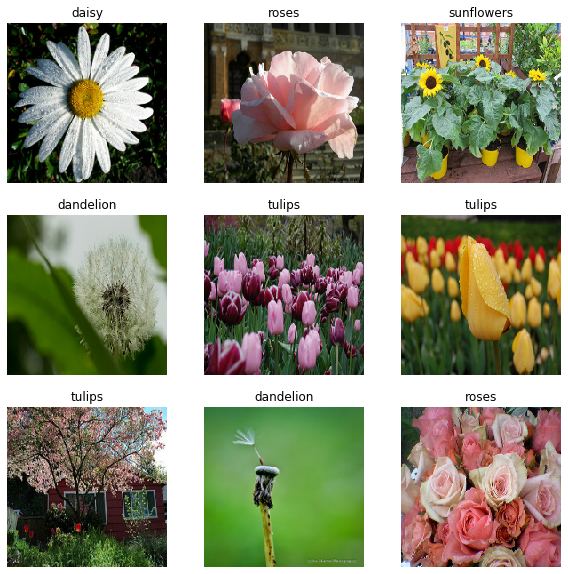

In [79]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


In [78]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>

In [82]:
len(label_batch)

32

### 모델 계속 훈련하기
위의 `keras.preprocessing`에 의해 작성된 것과 유사한 `tf.data.Dataset`를 수동으로 빌드. 모델 훈련을 계속할 수 있다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 가지 epoch 동안 훈련

In [84]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3)

Epoch 1/3
92/92 [==============================] - 31s 332ms/step - loss: 0.7844 - accuracy: 0.6972 - val_loss: 0.7765 - val_accuracy: 0.7125
Epoch 2/3
92/92 [==============================] - 30s 322ms/step - loss: 0.5835 - accuracy: 0.7800 - val_loss: 0.7674 - val_accuracy: 0.7016
Epoch 3/3
92/92 [==============================] - 30s 323ms/step - loss: 0.3909 - accuracy: 0.8648 - val_loss: 0.9142 - val_accuracy: 0.6989


### Tensorflow 데이터 세트 사용하기
이 튜토리얼에서는 지금까지 디스크에서 데이터를 로드하는 데 중점을 두었다. tensorflow 데이터세트에서 다운로드하기 쉬운 대규모 데이터세트 카탈로그를 탐색하여 사용할 데이터세트를 찾을 수도 있다. 이전에 Flowers 데이터세트를 디스크에서 로드했으므로 Tensorflow 데이터 세트로 가져오는 방법을 살펴보겠다.

Tensorflow 데이터세트를 사용하여 꽃 데이터세트를 다운로드한다

In [85]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,)



Dataset tf_flowers downloaded and prepared to /home/hj20/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스

In [87]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색

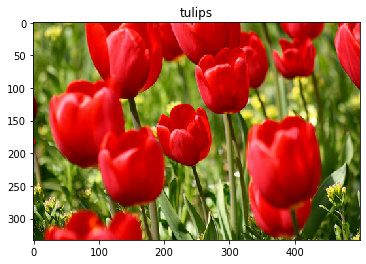

In [90]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_=plt.imshow(image)
_=plt.title(get_label_name(label))

In [91]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)